In [1]:
import logging
from lisa.utils import setup_logging
setup_logging()

2018-10-16 12:45:35,229 INFO    : root         : Using LISA logging configuration:
2018-10-16 12:45:35,230 INFO    : root         :   /data/work/lisa/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from lisa.env import TestEnv, TargetConf
from lisa.platform import PlatformInfo

# Support for trace events analysis
from lisa.trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import pandas as pd

from lisa.wlgen.rta import RTA, Periodic, Ramp
from time import sleep

from IPython.display import display, Image
from IPython.display import Image

2018-10-16 12:45:35,531 INFO    : root         : Generating grammar tables from /usr/lib/python3.5/lib2to3/Grammar.txt
2018-10-16 12:45:35,554 INFO    : root         : Generating grammar tables from /usr/lib/python3.5/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


In [3]:
# This is information only relevant to create a
# connection between the host and the target
target_conf = TargetConf({
    "kind" : "linux",
    "board" : "hikey960",
    "host": "192.168.0.1",
    "username" : "root",
    "password" : "root",
})

In [4]:
te = TestEnv(target_conf)
target = te.target

2018-10-16 12:45:35,944 INFO    : lisa.env.TestEnv : Pre-configured platform information:

2018-10-16 12:45:35,946 INFO    : lisa.env.TestEnv : Using base path: /data/work/lisa
2018-10-16 12:45:36,055 INFO    : lisa.env.TestEnv : linux hikey960 target connection settings:
2018-10-16 12:45:36,056 INFO    : lisa.env.TestEnv :       port : 22
2018-10-16 12:45:36,057 INFO    : lisa.env.TestEnv :   password : root
2018-10-16 12:45:36,059 INFO    : lisa.env.TestEnv :       host : 192.168.0.1
2018-10-16 12:45:36,060 INFO    : lisa.env.TestEnv :   username : root
2018-10-16 12:45:36,079 INFO    : lisa.env.TestEnv : Devlib modules to load: ['bl', 'cgroups', 'cpufreq', 'cpuidle', 'devfreq', 'fastboot', 'gem5stats', 'gpufreq', 'hotplug', 'hwmon', 'mbed-fan', 'odroidxu3-fan', 'sched', 'thermal']
2018-10-16 12:45:40,534 WARNING : LinuxTarget  : Module devfreq is not supported by the target
2018-10-16 12:45:40,537 WARNING : LinuxTarget  : Module fastboot is not supported by the target
2018-10-16 12:

# Live target experimentation

In [5]:
from lisa.tests.kernel.scheduler.eas_behaviour import EnergyModelWakeMigration

We want to create a TestBundle from a live target, so we can use the **from_testenv** alternative constructor:

In [6]:
bundle = EnergyModelWakeMigration.from_testenv(te)

2018-10-16 12:46:06,581 INFO    : lisa.wlgen.rta.RTA : CPU0 calibration...
2018-10-16 12:46:06,916 INFO    : lisa.wlgen.rta.RTA : Calibration value: CPU0
2018-10-16 12:46:06,917 INFO    : lisa.wlgen.rta.RTA : Default policy: SCHED_OTHER
2018-10-16 12:46:06,919 INFO    : lisa.wlgen.rta.RTA : ------------------------
2018-10-16 12:46:06,920 INFO    : lisa.wlgen.rta.RTA : task [task1], sched: using default policy
2018-10-16 12:46:06,921 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2018-10-16 12:46:06,922 INFO    : lisa.wlgen.rta.RTA :  | loops count: 1
2018-10-16 12:46:06,923 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2018-10-16 12:46:06,925 INFO    : lisa.wlgen.rta.Phase :  | batch 0.001000 [s]
2018-10-16 12:46:07,176 INFO    : lisa.wlgen.rta.RTA : Execution start: /root/devlib-target/bin/rt-app /root/devlib-target/rta_calib_cpu0.json 2>&1
2018-10-16 12:46:13,706 INFO    : lisa.wlgen.rta.RTA : Execution complete
2018-10-16 12:46:13,944 INFO    : lisa.wlgen.rta.RTA : CP

2018-10-16 12:47:08,002 INFO    : lisa.wlgen.rta.Phase :  | duration 2.000000 [s] (125 loops)
2018-10-16 12:47:08,003 INFO    : lisa.wlgen.rta.Phase :  |  period    16000 [us], duty_cycle   9 %
2018-10-16 12:47:08,004 INFO    : lisa.wlgen.rta.Phase :  |  run_time   1440 [us], sleep_time  14560 [us]
2018-10-16 12:47:08,005 INFO    : lisa.wlgen.rta.RTA :  + phase_000002
2018-10-16 12:47:08,007 INFO    : lisa.wlgen.rta.Phase :  | duration 2.000000 [s] (125 loops)
2018-10-16 12:47:08,008 INFO    : lisa.wlgen.rta.Phase :  |  period    16000 [us], duty_cycle  70 %
2018-10-16 12:47:08,009 INFO    : lisa.wlgen.rta.Phase :  |  run_time  11200 [us], sleep_time   4800 [us]
2018-10-16 12:47:08,010 INFO    : lisa.wlgen.rta.RTA : ------------------------
2018-10-16 12:47:08,011 INFO    : lisa.wlgen.rta.RTA : task [emwm_2], sched: using default policy
2018-10-16 12:47:08,012 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2018-10-16 12:47:08,013 INFO    : lisa.wlgen.rta.RTA :  | loops cou

We now have a **TestBundle** instance. We're free to play around with its data, more specifically to execute some tests related to this data:

In [7]:
print(bundle.test_slack())

PASSED: emwm_0 slack=2.8 %, emwm_3 slack=2.8 %, emwm_2 slack=3.0 %, emwm_1 slack=2.8 %


Whenever possible, we want to expose test margins to the end user. Here, we can change the failure threshold, and for the sake of demonstration we'll set it way too low (and expect a failure)

In [8]:
print(bundle.test_slack(negative_slack_allowed_pct=1))

FAILED: emwm_0 slack=2.8 %, emwm_3 slack=2.8 %, emwm_2 slack=3.0 %, emwm_1 slack=2.8 %


This test also produces a plot, let's run it and have a look

In [9]:
print(bundle.test_task_placement())

PASSED: energy threshold=12697.384476751002 bogo-joules, estimated energy=11238.592523718557 bogo-joules


In [10]:
trappy.plotter.plot_trace(bundle.trace.ftrace, execnames=list(bundle.rtapp_profile.keys()))

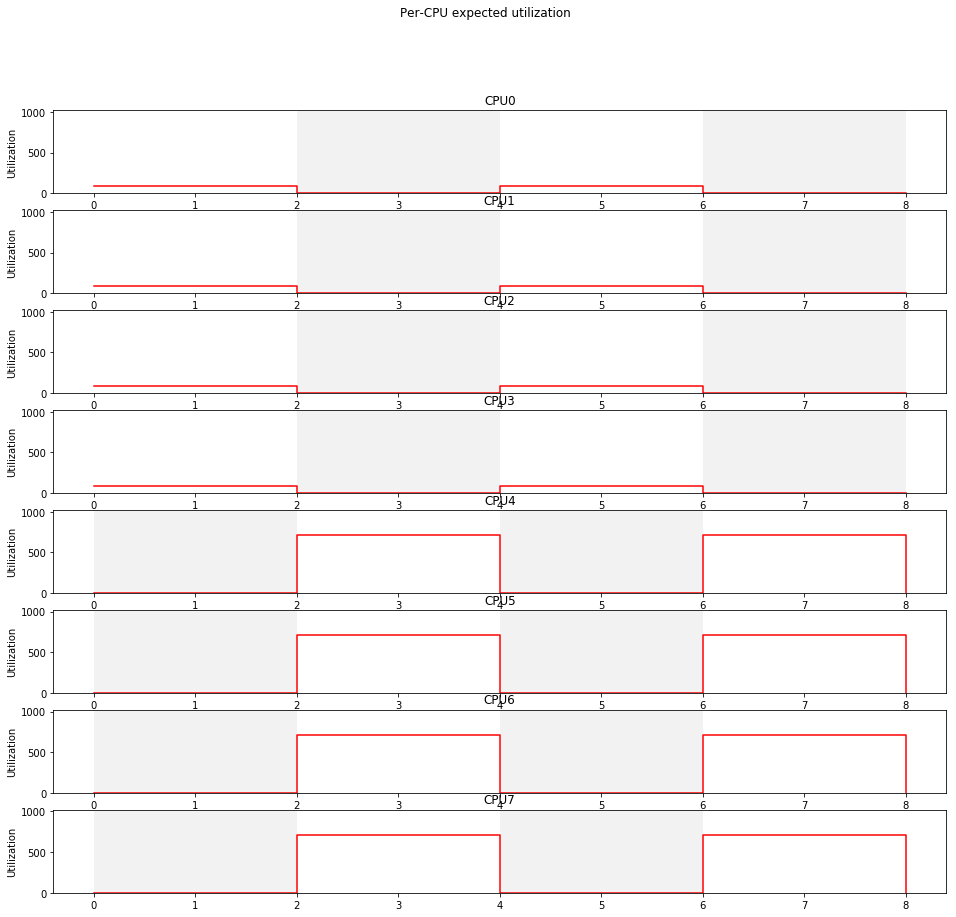

In [11]:
image_path = os.path.join(bundle.res_dir, "expected_placement.png")
Image(image_path)

# Offline replaying

Say someone executed some tests, and ran into some issues. They can create an archive of the results directory and send it your way, and you'll be able to reload it automagically. This also works if you are working on the test code itself, and don't want to re-execute the workload every single time you change the code.

In [12]:
# Let's just reuse what was generated in the previous run
archive_dir = bundle.res_dir

In [13]:
reloaded_bundle = EnergyModelWakeMigration.from_dir(archive_dir)

In [14]:
# Just to prove we're not cheating!
reloaded_bundle == bundle

False

In [15]:
print(reloaded_bundle.test_task_placement())

PASSED: energy threshold=12697.384476751002 bogo-joules, estimated energy=11238.592523718557 bogo-joules
